In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import shap


df = pd.read_csv('df_22_24.csv')
df.index = pd.date_range(start='2022-11-01', periods=len(df), freq='H')

df = df.loc['2023-01-01':'2024-01-14'].copy()

targets = [
    'Price_positive_secondary',
    'Price_negative_secondary',
    'Price_positive_tertiary',
    'Price_negative_tertiary'
]

percentile = 0.2
static_q = 1 - percentile

k_std = 1

rolling_time = 24 * 7 * 4 * 2  # Seasonal rolling window of 4 months

ModuleNotFoundError: No module named 'pandas'

## Data clean

In [49]:
# Include all other features in the model
other_feats = [c for c in df.columns if c not in targets]

# Day dependancy?
# df['hour'] = df.index.hour
# df['weekday'] = df.index.weekday

# Lagged price features
lags = [1, 2, 24]
for t in targets:
    for lag in lags:
        df[f'{t}_lag{lag}'] = df[t].shift(lag)
        
# Combine feature columns
feature_cols = [f'{t}_lag{lag}' for t in targets for lag in lags] + other_feats #+ ['hour', 'weekday']
# Drop rows with missing features
df = df.dropna(subset=feature_cols)

## Training 

In [50]:
split_date = '2023-10-01'
X = df[feature_cols]
X_train, X_test = X.loc[:split_date], X.loc[split_date:]

In [51]:
def analyze_xgb_model(X_tr, y_tr, X_te, y_te, name, n_splits=5):
    """
    Trains an XGBClassifier with time-series CV, prints evaluation metrics, and conducts SHAP analysis
    including beeswarm, bar plot, and waterfall for model interpretability.
    """
    # Hyperparameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'alpha': [0.01, 0.3],
        'lambda': [0.01, 0.3],
    }
    # TimeSeries split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        scoring='f1',
        cv=tscv,
        n_jobs=-1,
        verbose=False
    )
    rs.fit(X_tr, y_tr)
    best_model = rs.best_estimator_
    print(f"=== {name} ===")
    print("Best params:", rs.best_params_)

    # Predictions and metrics
    y_pred = best_model.predict(X_te)
    rec = recall_score(y_te, y_pred)
    pre = precision_score(y_te, y_pred)
    f1s = f1_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)
    print(f"Recall: {rec:.3f}, Precision: {pre:.3f}, F1: {f1s:.3f}")
    print("Confusion Matrix:\n", cm)

    # --- SHAP Value Analysis ---
    print("\nPerforming SHAP Value Analysis...")
    explainer = shap.Explainer(best_model, X_tr)
    shap_values = explainer(X_te)

    # 1. SHAP Summary Beeswarm Plot
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, X_te, plot_type="dot", show=False)
    plt.title("SHAP Beeswarm Plot")
    plt.tight_layout()
    plt.show()

    # 2. SHAP Bar Plot (Global Feature Importance)
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, X_te, plot_type="bar", show=False)
    plt.title("SHAP Bar Plot")
    plt.tight_layout()
    plt.show()

    # 3. SHAP Waterfall Plot (for a single prediction)
    instance_idx = 0  # Index of the instance to analyze
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap_values[instance_idx], show=False)
    plt.title(f"SHAP Waterfall Plot for Instance {instance_idx}")
    plt.tight_layout()
    plt.show()

    return best_model, rec, pre, f1s, cm

### Percentile threshold

=== Static_Price_positive_secondary ===
Best params: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 1.0, 'alpha': 0.3}
Recall: 0.879, Precision: 0.695, F1: 0.776
Confusion Matrix:
 [[2167  105]
 [  33  239]]

Performing SHAP Value Analysis...


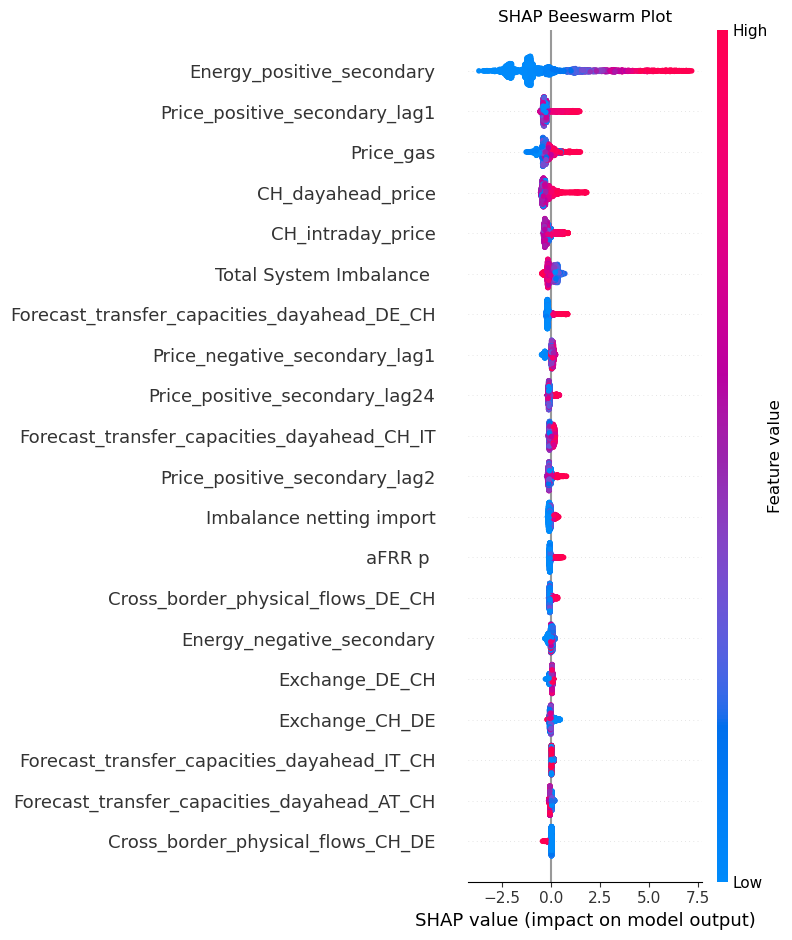

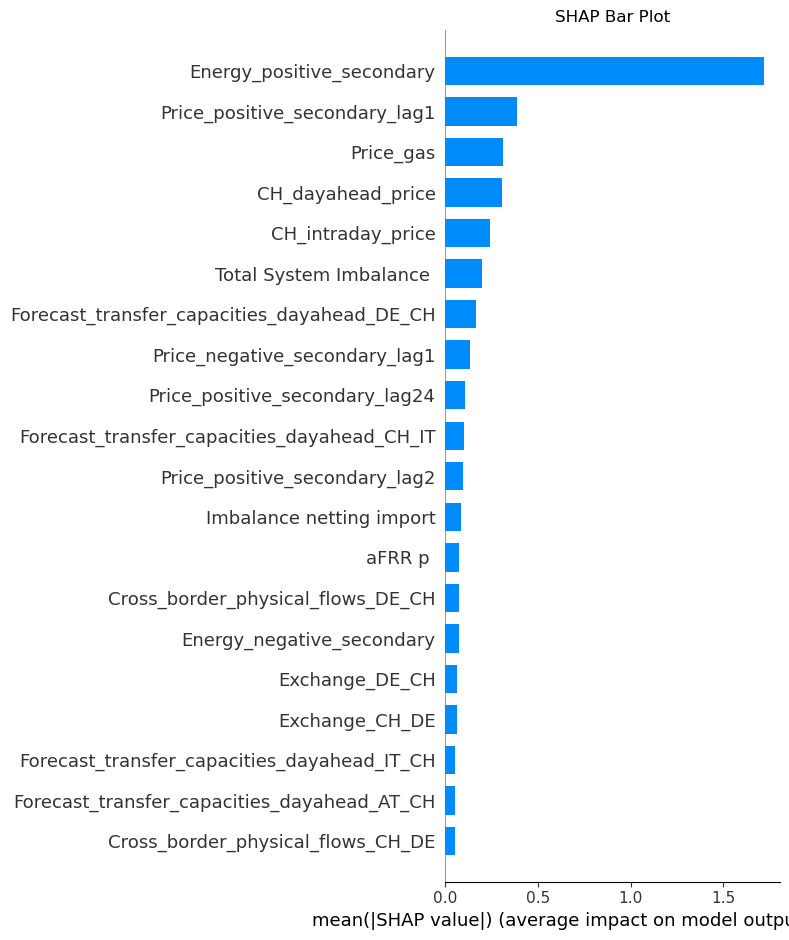

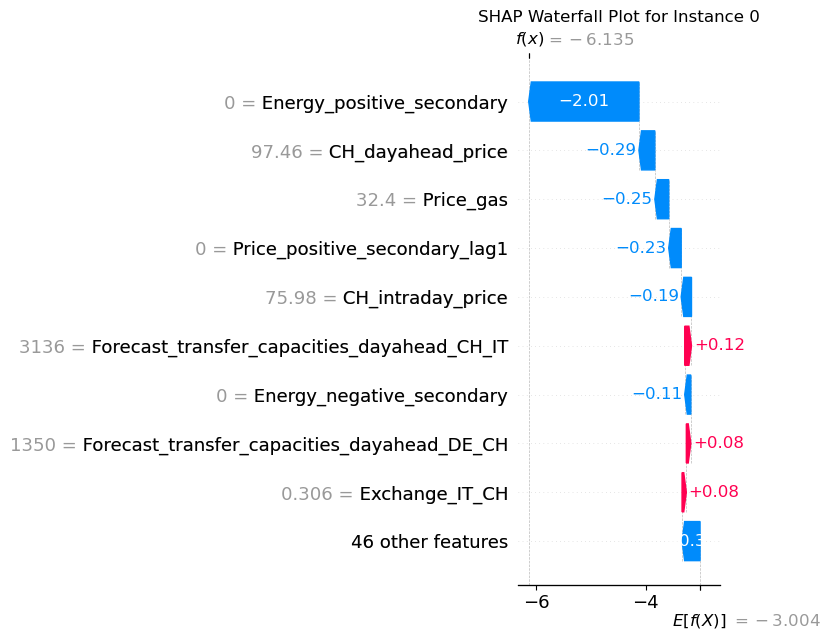

=== Static_Price_negative_secondary ===
Best params: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 0.3, 'colsample_bytree': 1.0, 'alpha': 0.3}
Recall: 0.615, Precision: 0.698, F1: 0.654
Confusion Matrix:
 [[2077   98]
 [ 142  227]]

Performing SHAP Value Analysis...


 94%|=================== | 2383/2544 [00:18<00:01]       

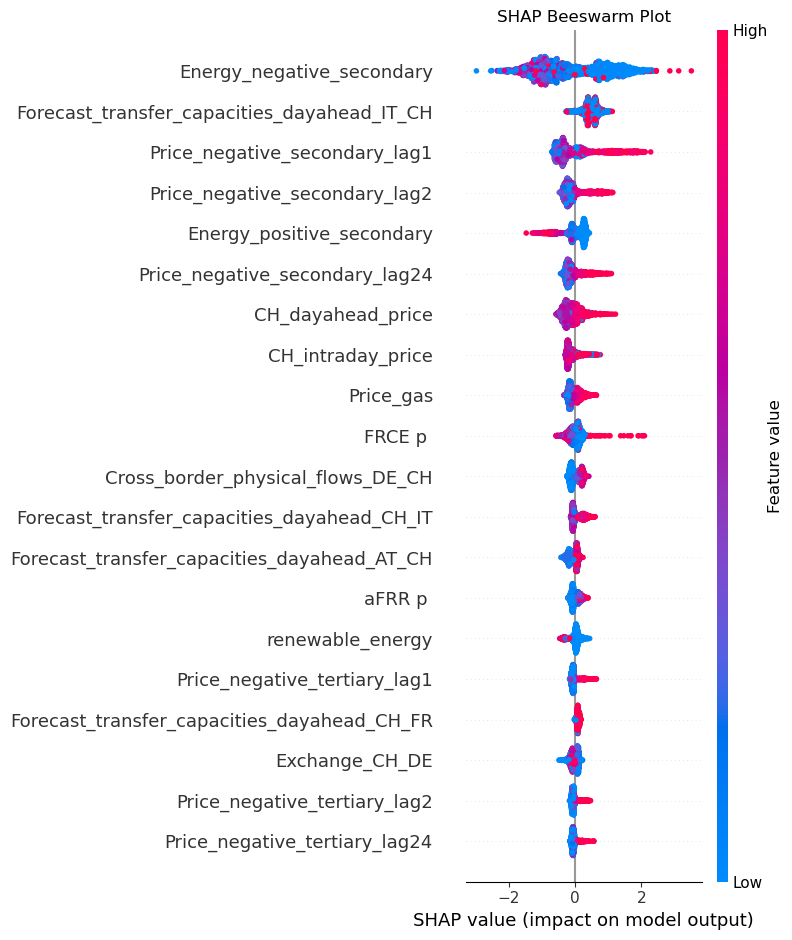

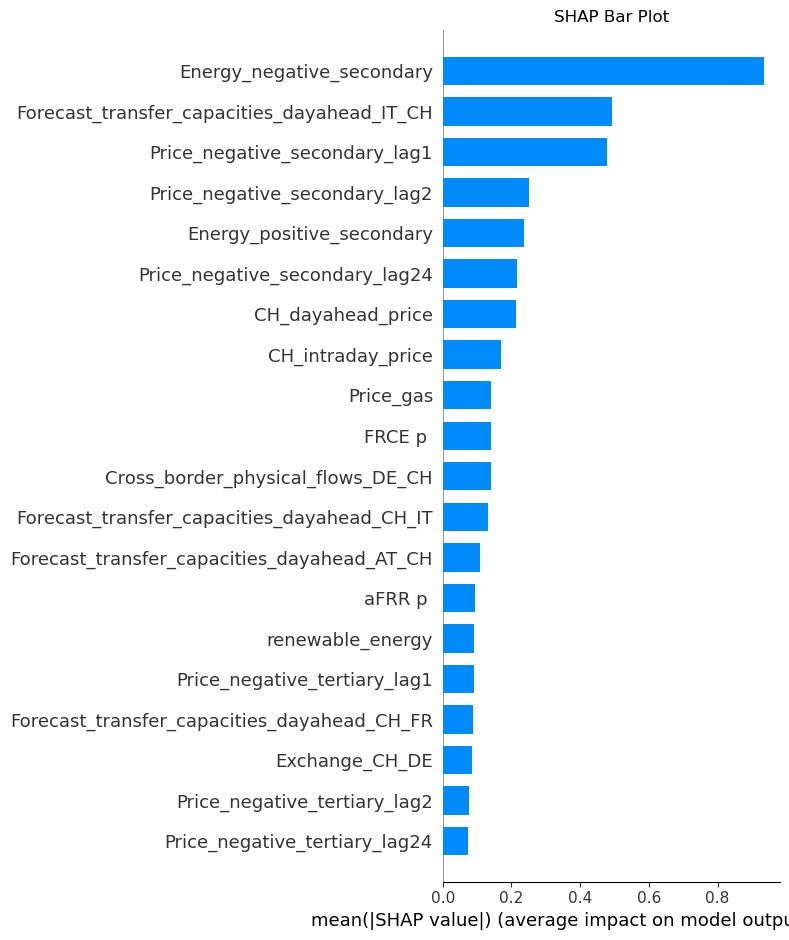

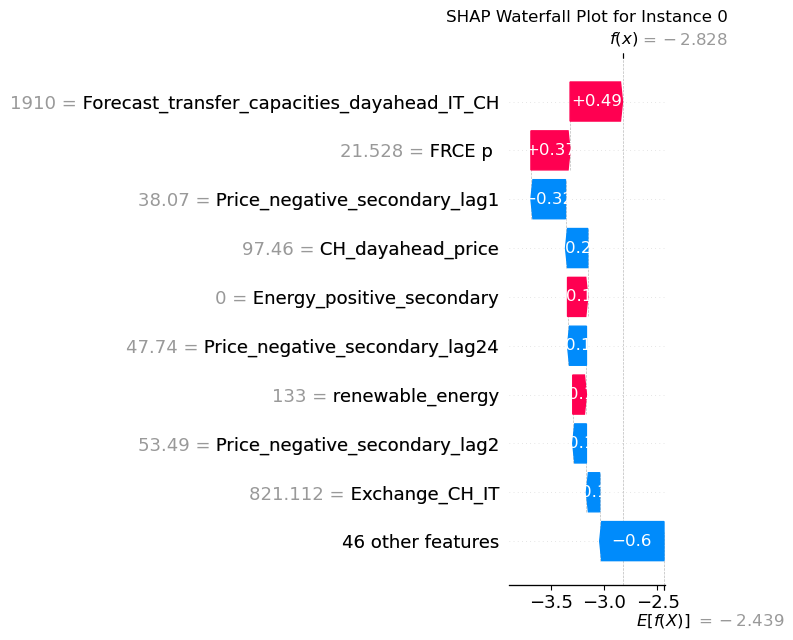

=== Static_Price_positive_tertiary ===
Best params: {'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.3, 'colsample_bytree': 0.7, 'alpha': 0.01}
Recall: 0.888, Precision: 0.749, F1: 0.813
Confusion Matrix:
 [[2059  111]
 [  42  332]]

Performing SHAP Value Analysis...


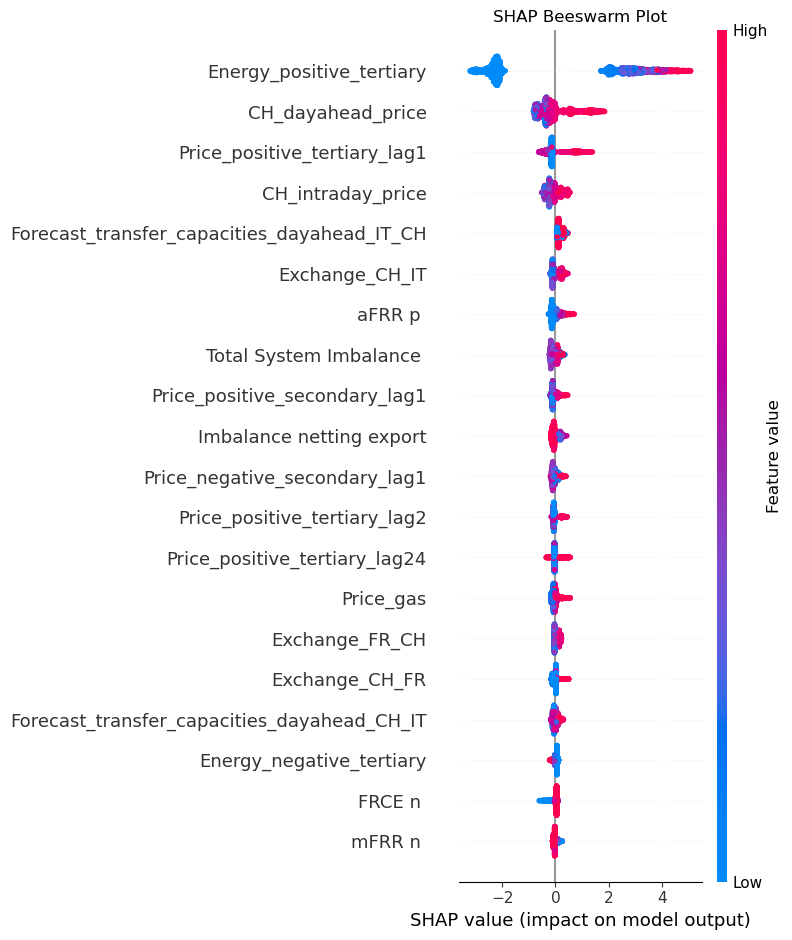

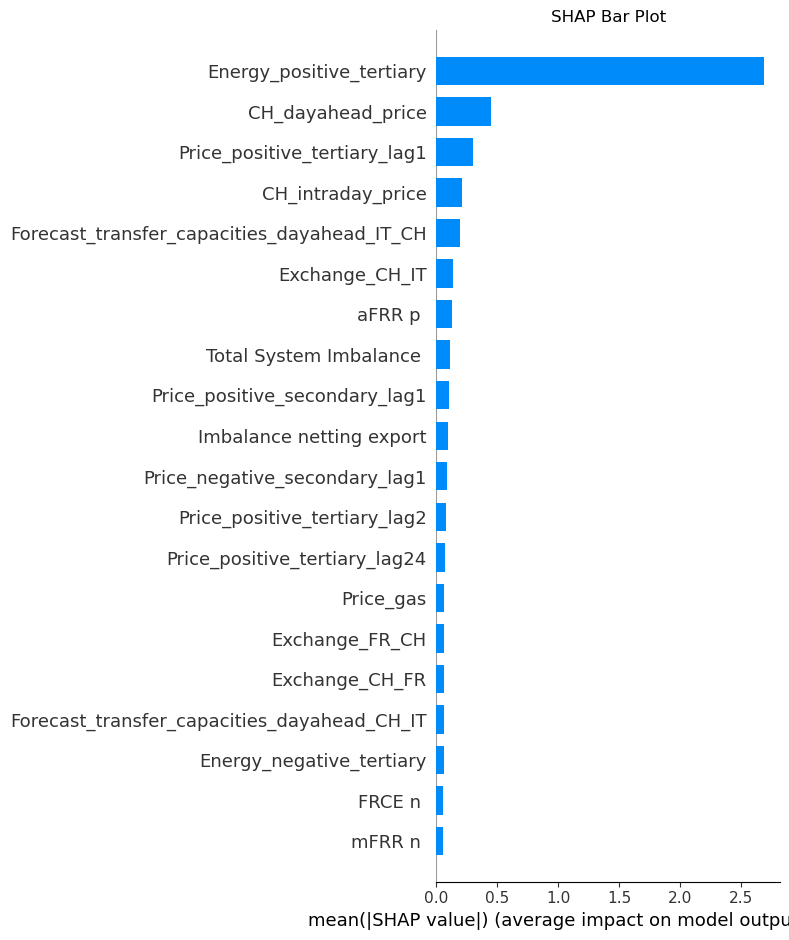

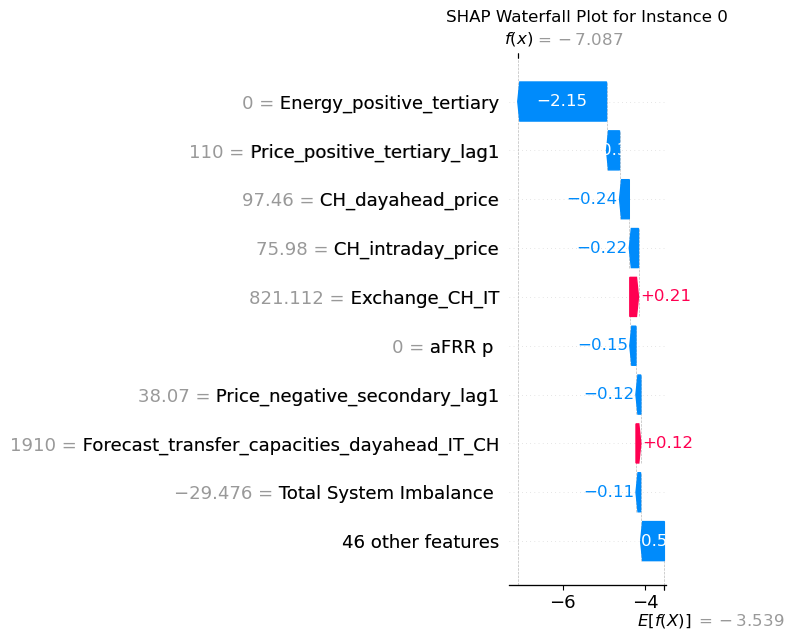

=== Static_Price_negative_tertiary ===
Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 1.0, 'alpha': 0.3}
Recall: 0.893, Precision: 0.809, F1: 0.849
Confusion Matrix:
 [[2182   63]
 [  32  267]]

Performing SHAP Value Analysis...


 99%|===================| 2517/2544 [00:18<00:00]        

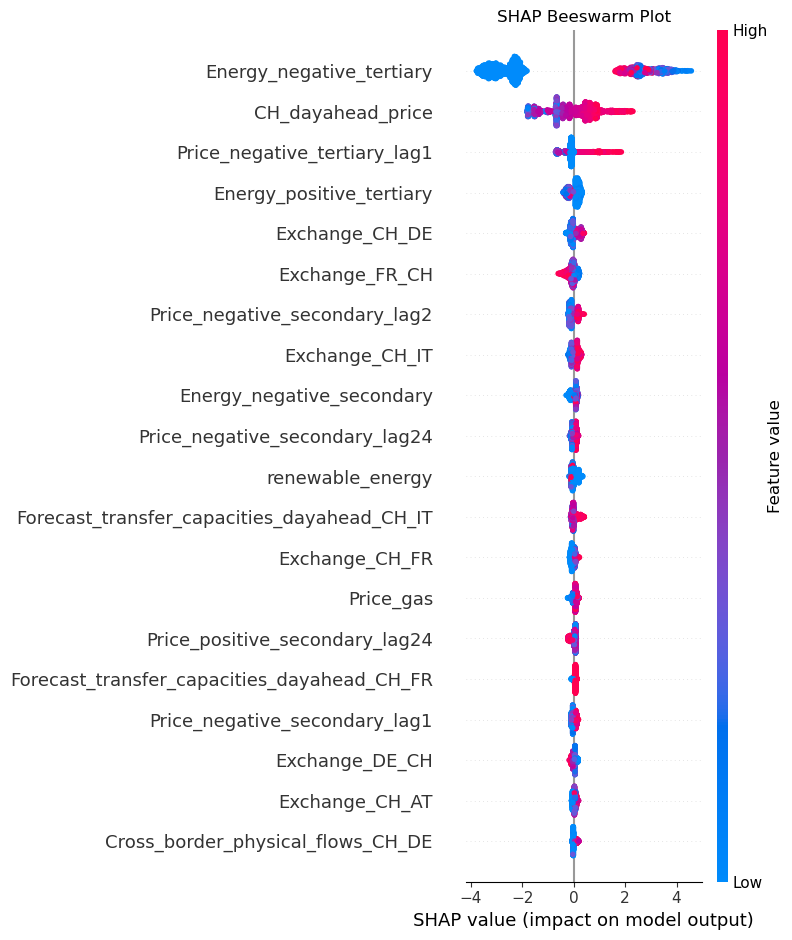

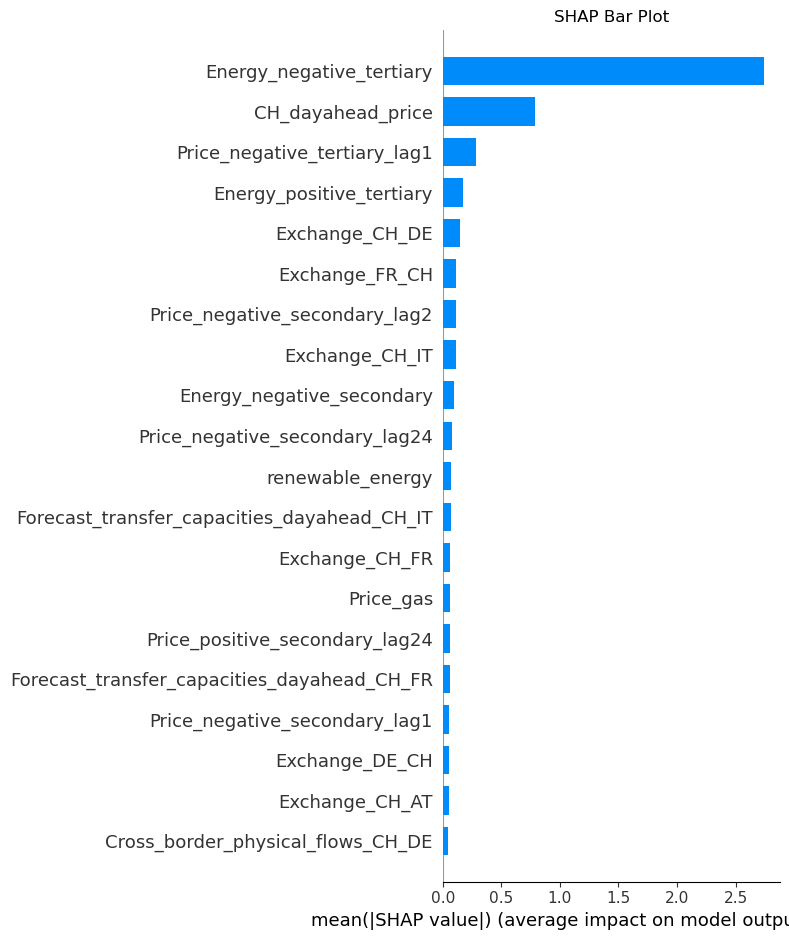

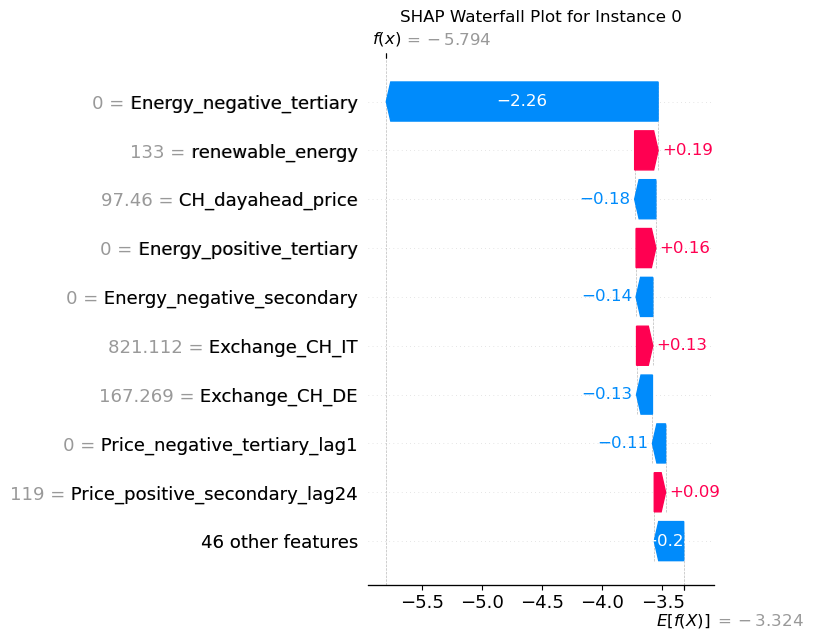

AttributeError: 'list' object has no attribute 'best_model'

In [ ]:
static_results = []
for t in targets:
    abs_ser = df[t].abs()
    thr = abs_ser.quantile(static_q)
    df[f'is_spike_{t}_static'] = (abs_ser >= thr).astype(int)

    y = df[f'is_spike_{t}_static']
    y_tr, y_te = y.loc[:split_date], y.loc[split_date:]

    best_model, rec_f, pre_f, f1_f, _ = analyze_xgb_model(X_train, y_tr, X_test, y_te, name=f"Static_{t}")
    static_results.append({'target':t, 'threshold':thr,
        'recall_full': rec_f,
        'precision_full': pre_f,
        'f1_full': f1_f, 'best_model': best_model})


### Dynamic threshold

$\tau = \mu + k * \sigma^2$

=== DynFull_Price_positive_secondary ===
Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 0.7, 'alpha': 0.01}
Recall: 0.825, Precision: 0.683, F1: 0.747
Confusion Matrix:
 [[2378   46]
 [  21   99]]

Performing SHAP Value Analysis...


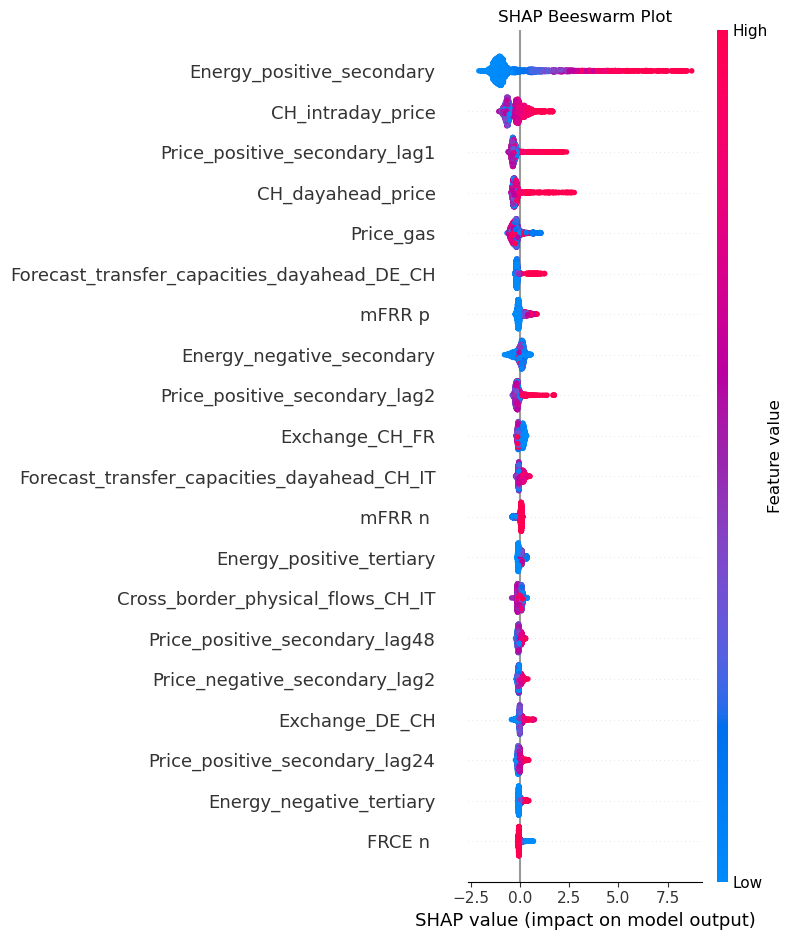

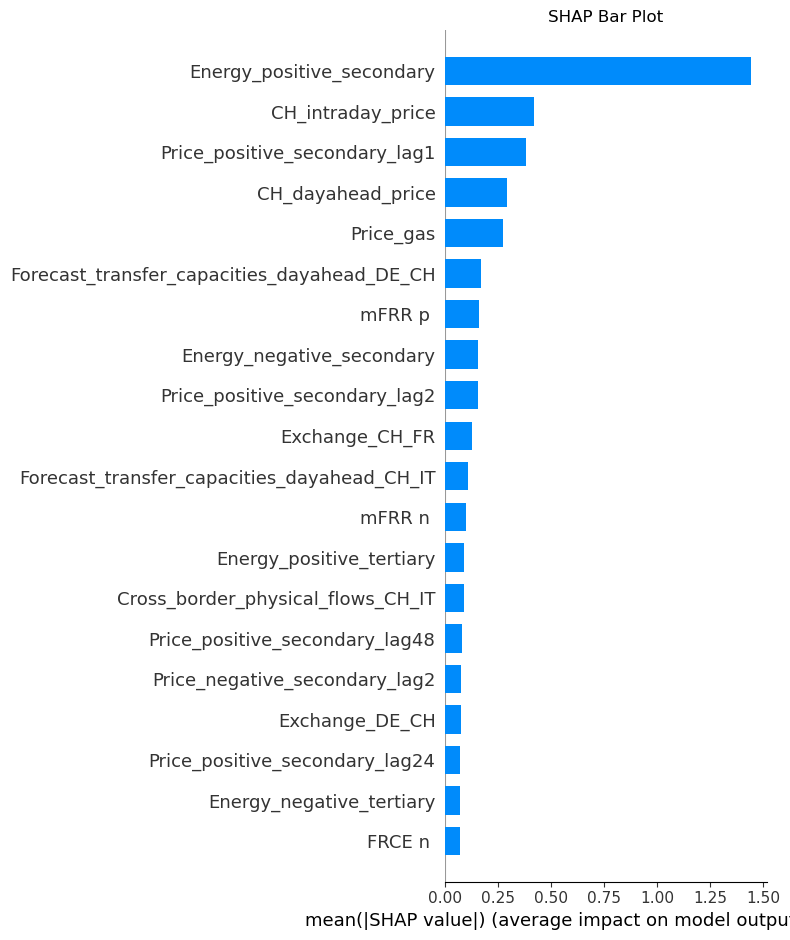

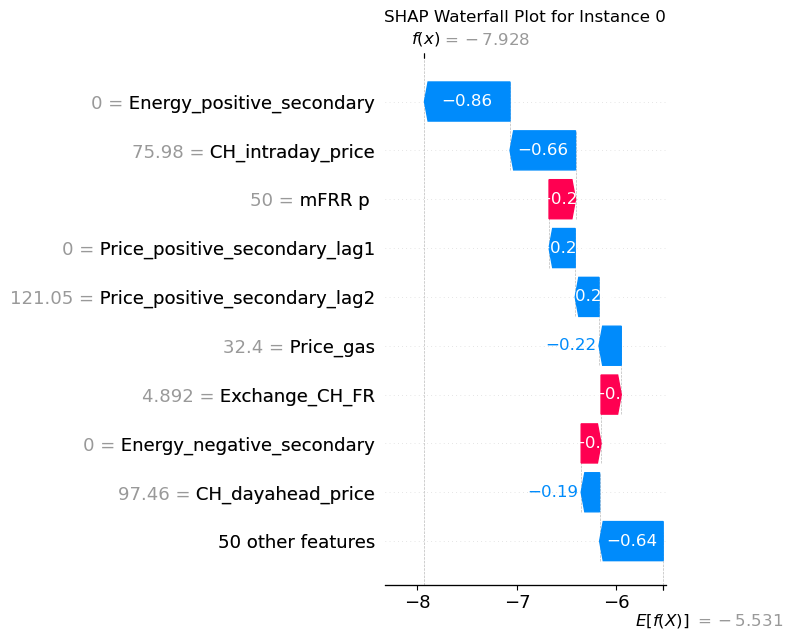

=== DynFull_Price_negative_secondary ===
Best params: {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 0.7, 'alpha': 0.01}
Recall: 0.200, Precision: 0.600, F1: 0.300
Confusion Matrix:
 [[2510    4]
 [  24    6]]

Performing SHAP Value Analysis...


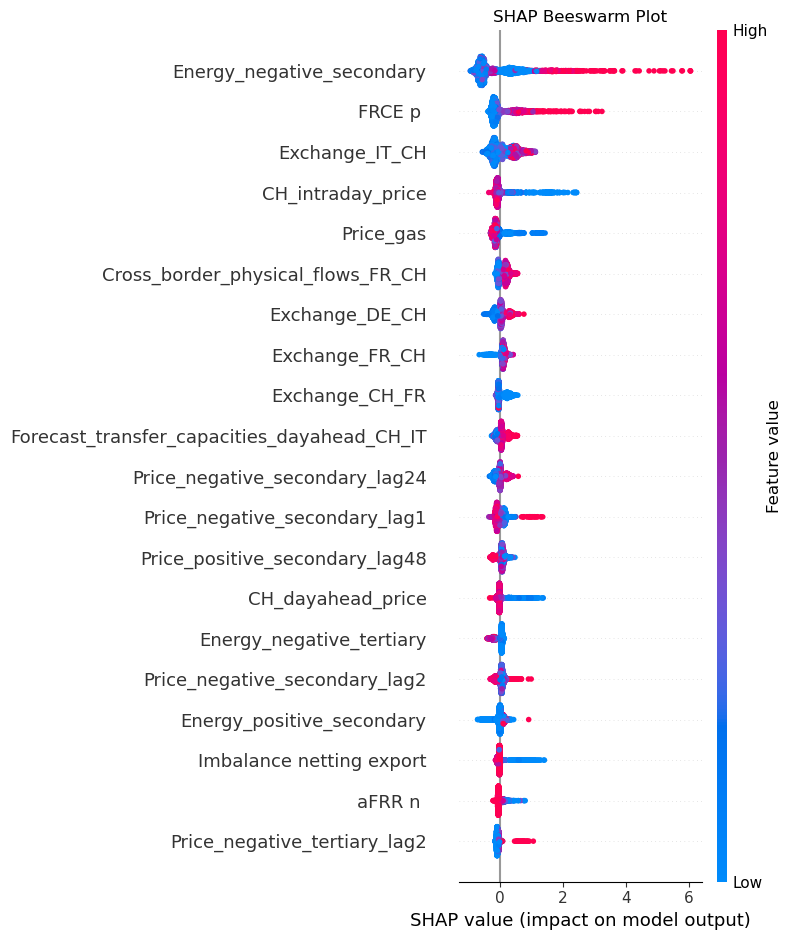

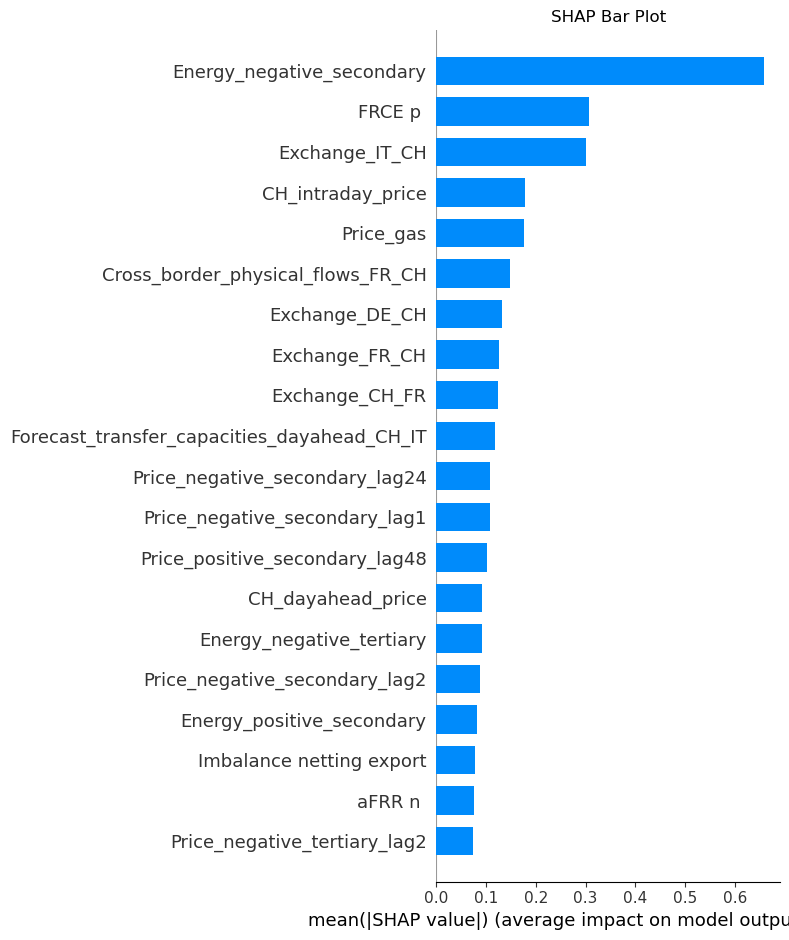

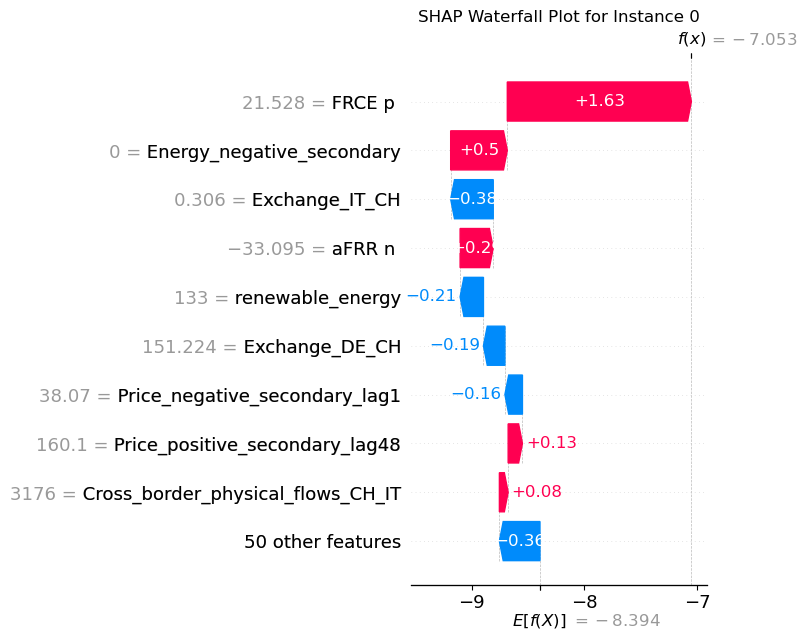

=== DynFull_Price_positive_tertiary ===
Best params: {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.3, 'colsample_bytree': 1.0, 'alpha': 0.01}
Recall: 0.500, Precision: 0.780, F1: 0.609
Confusion Matrix:
 [[2455   11]
 [  39   39]]

Performing SHAP Value Analysis...


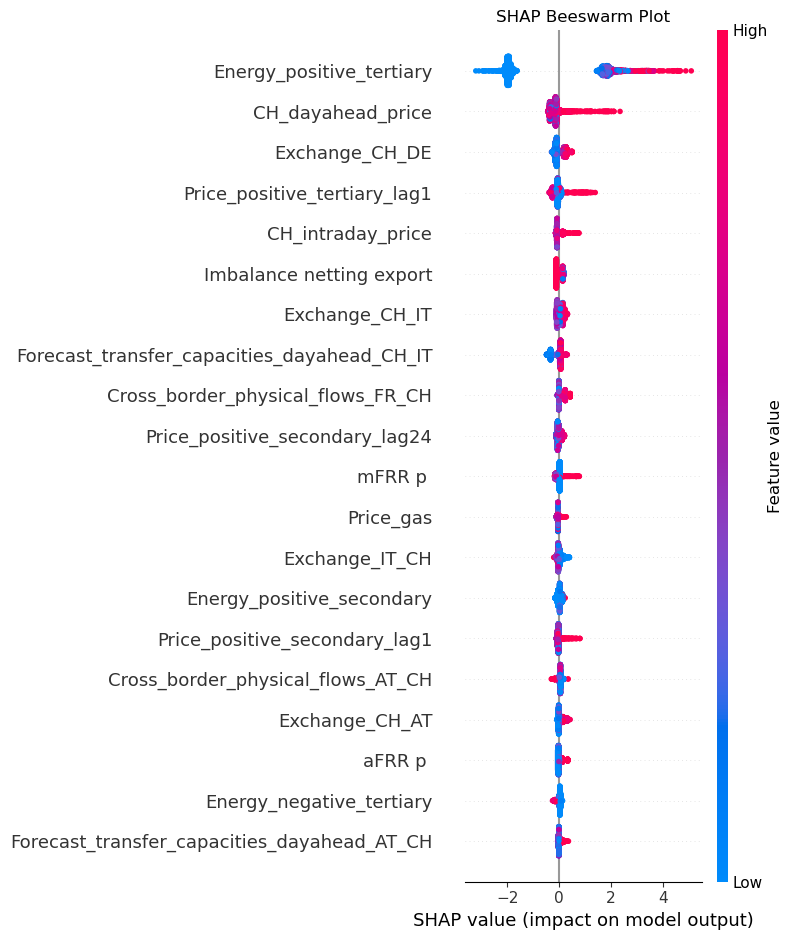

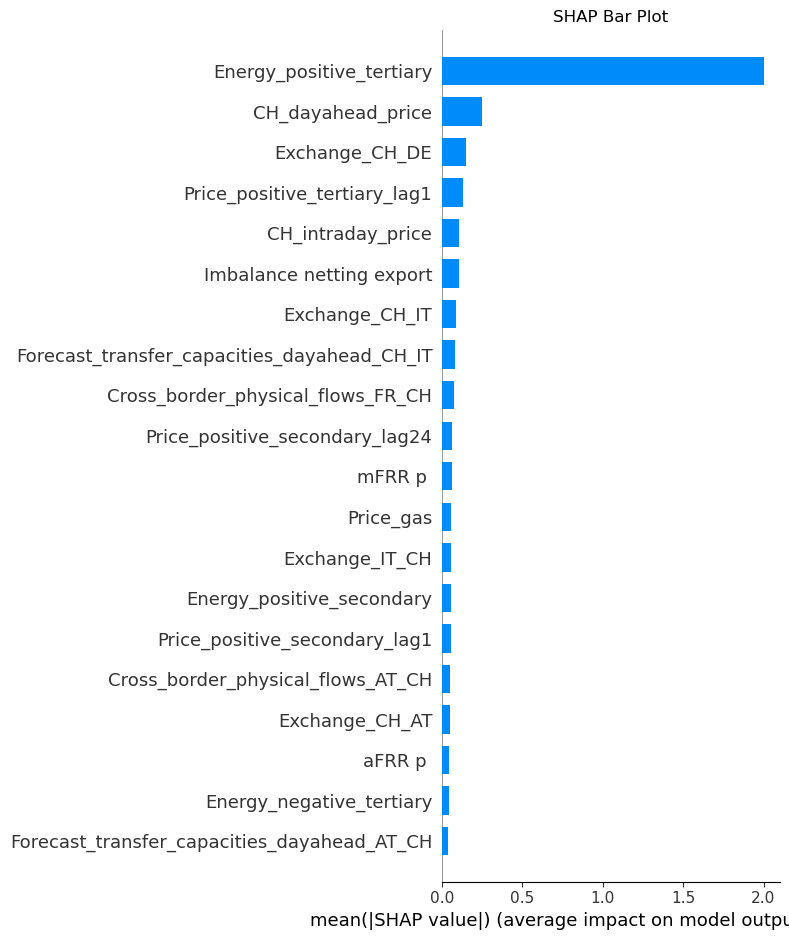

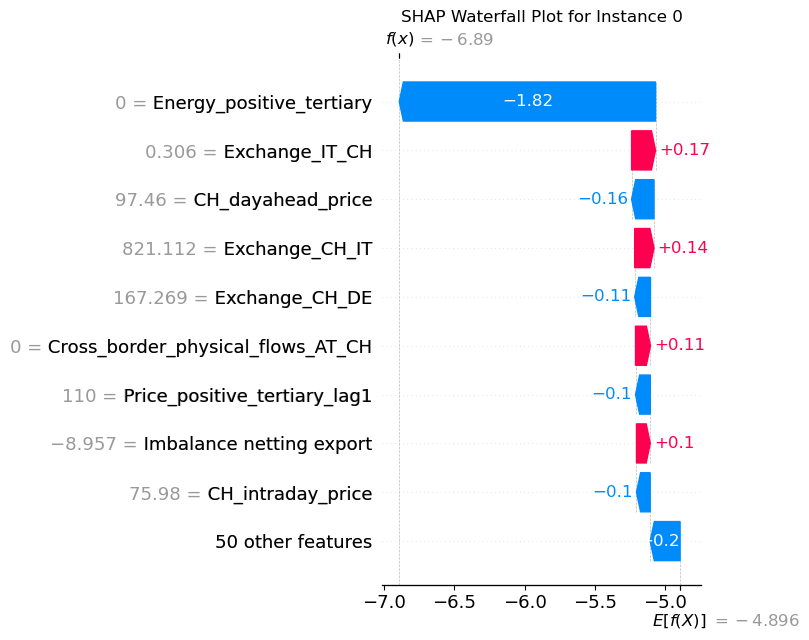

=== DynFull_Price_negative_tertiary ===
Best params: {'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 1.0, 'alpha': 0.3}
Recall: 0.568, Precision: 0.568, F1: 0.568
Confusion Matrix:
 [[2481   19]
 [  19   25]]

Performing SHAP Value Analysis...


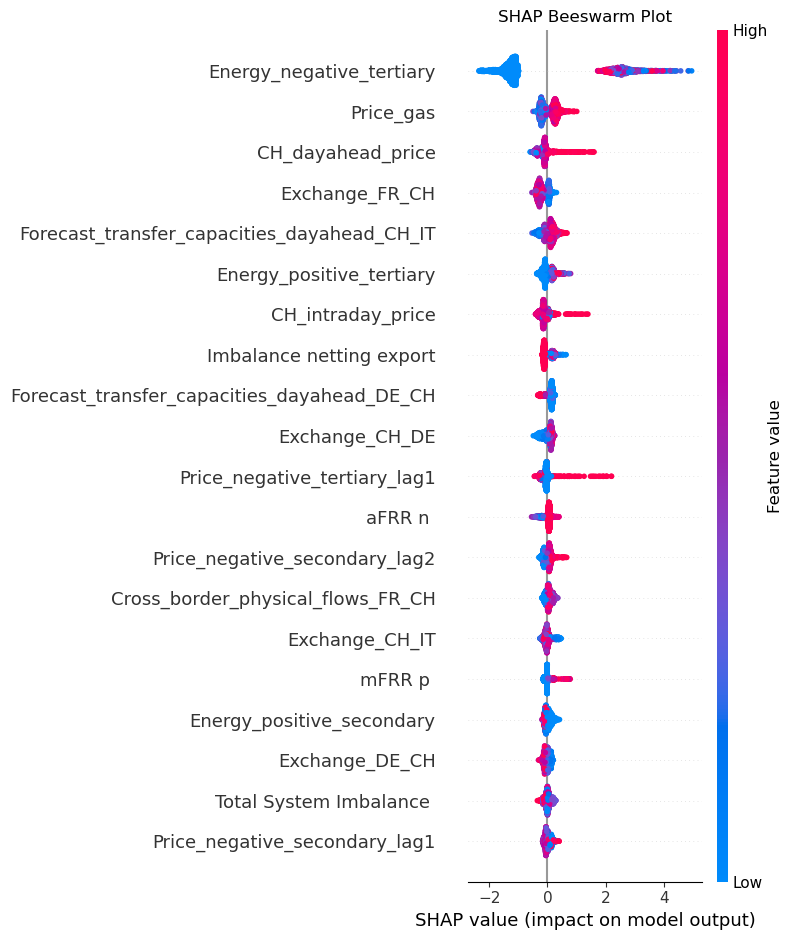

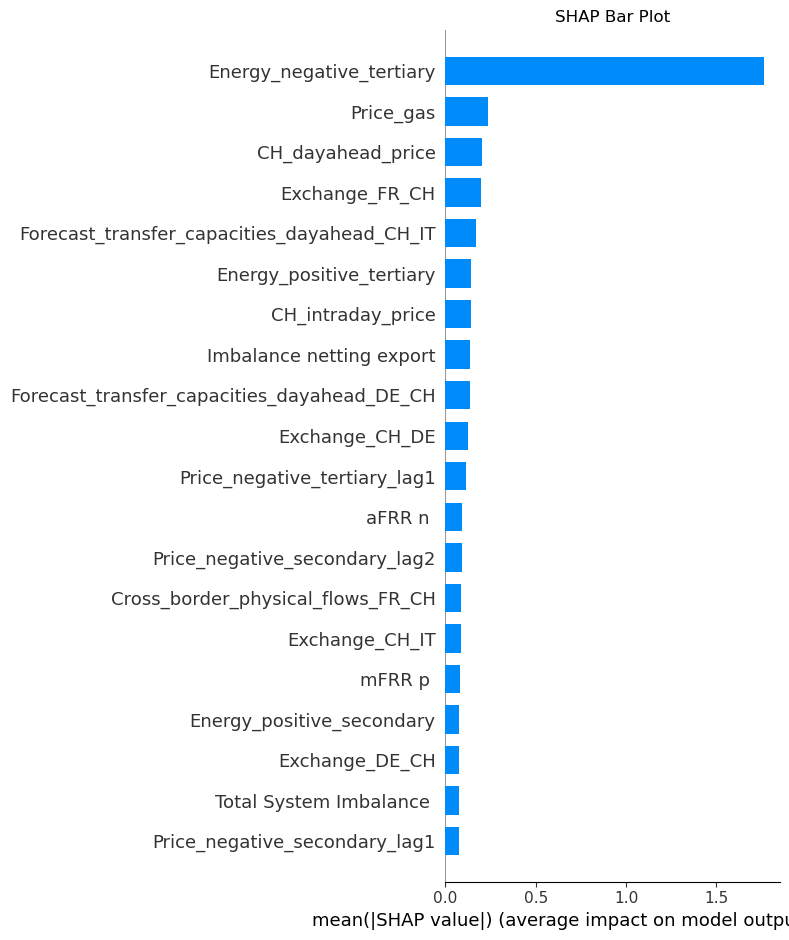

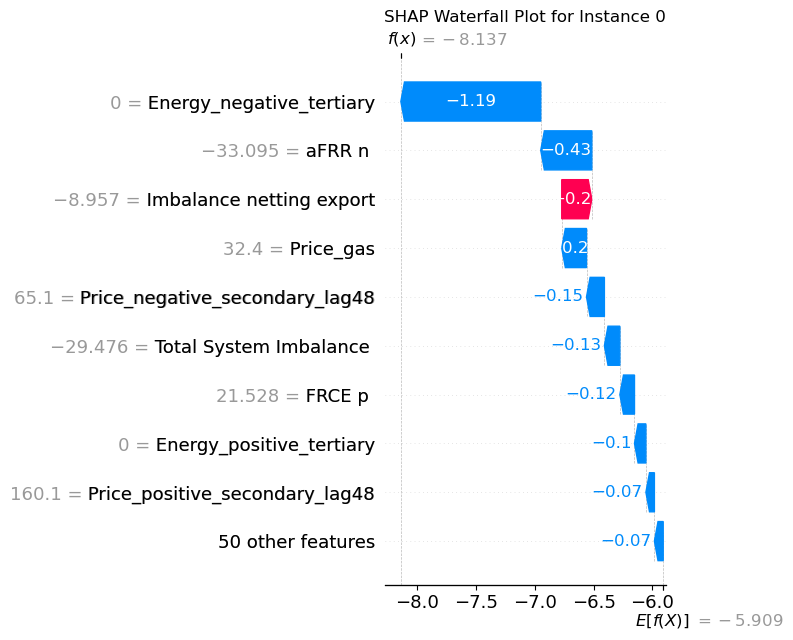

In [ ]:
df_dynfull_results = []
for t in targets:
    abs_series = df[t].abs()
    # Global threshold
    global_mean = abs_series.mean()
    global_std  = abs_series.std()
    full_thr = global_mean + k_std * global_std
    df[f'is_spike_{t}_dynfull'] = (abs_series >= full_thr).astype(int)

    # Train/test labels
    y_full = df[f'is_spike_{t}_dynfull']
    y_tr_full, y_te_full = y_full.loc[:split_date], y_full.loc[split_date:]

    # Evaluate
    _, rec_f, pre_f, f1_f, _ = analyze_xgb_model(
        X_train, y_tr_full, X_test, y_te_full,
        name=f"DynFull_{t}"
    )
    df_dynfull_results.append({
        'target': t,
        'full_thr': full_thr,
        'recall_full': rec_f,
        'precision_full': pre_f,
        'f1_full': f1_f
    })

### Weekly rolling

=== DynWeek_Price_positive_secondary ===
Best params: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 0.7, 'alpha': 0.01}
Recall: 0.361, Precision: 0.882, F1: 0.512
Confusion Matrix:
 [[2326   10]
 [ 133   75]]

Performing SHAP Value Analysis...


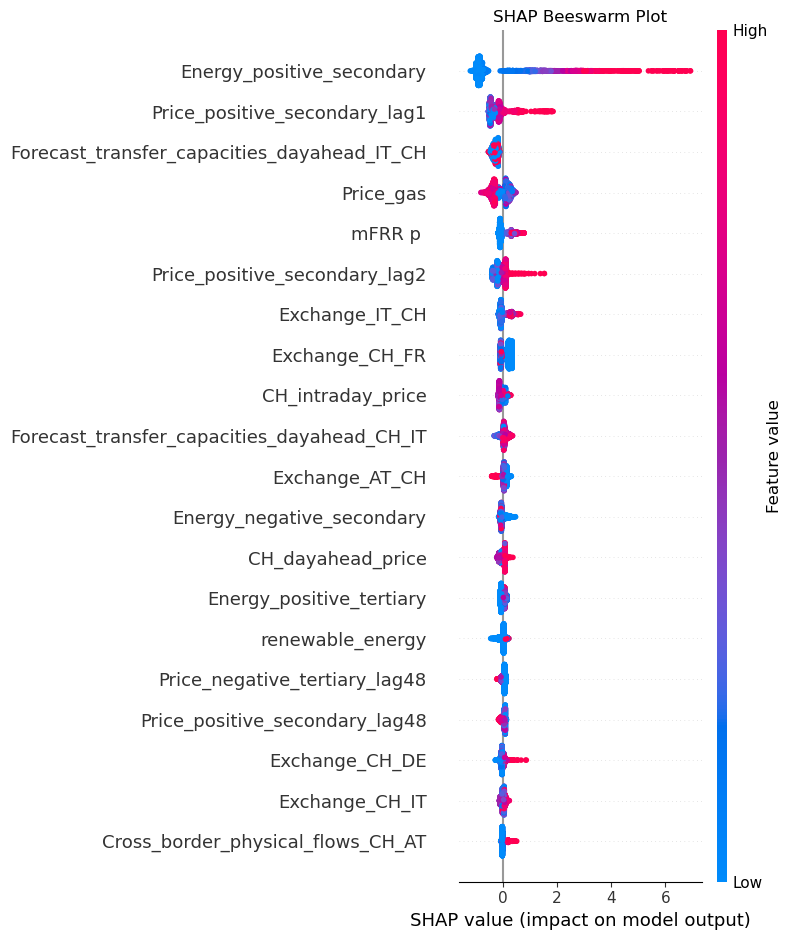

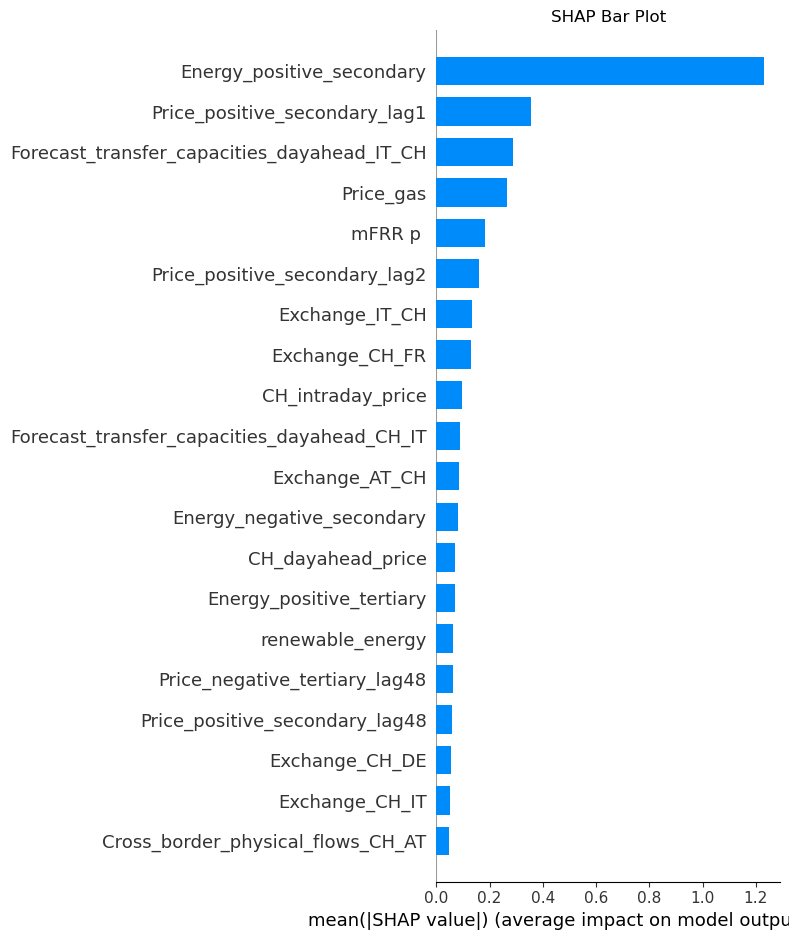

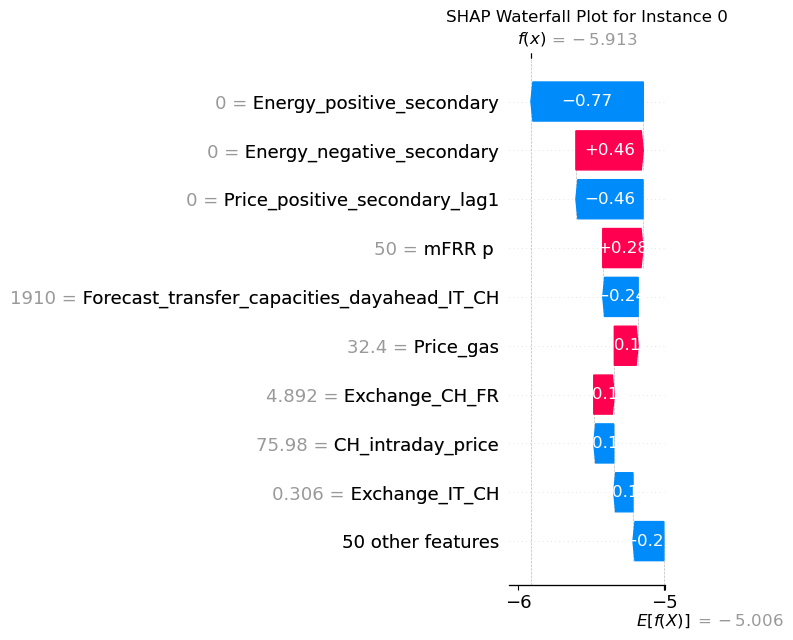

=== DynWeek_Price_negative_secondary ===
Best params: {'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 1.0, 'alpha': 0.3}
Recall: 0.108, Precision: 0.692, F1: 0.187
Confusion Matrix:
 [[2457    4]
 [  74    9]]

Performing SHAP Value Analysis...


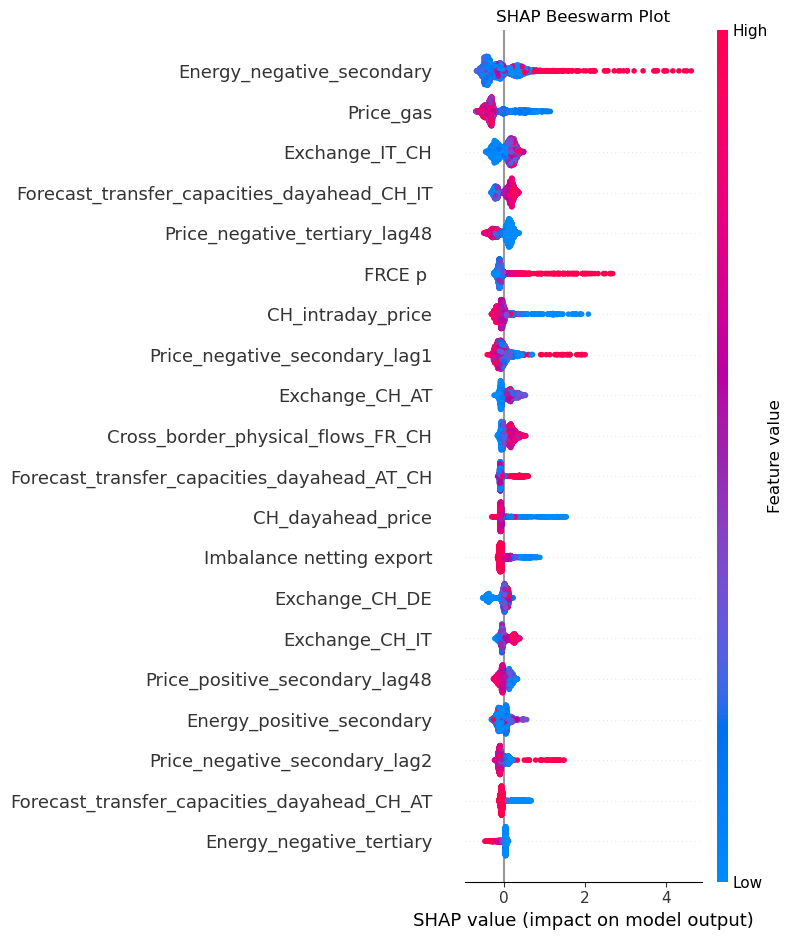

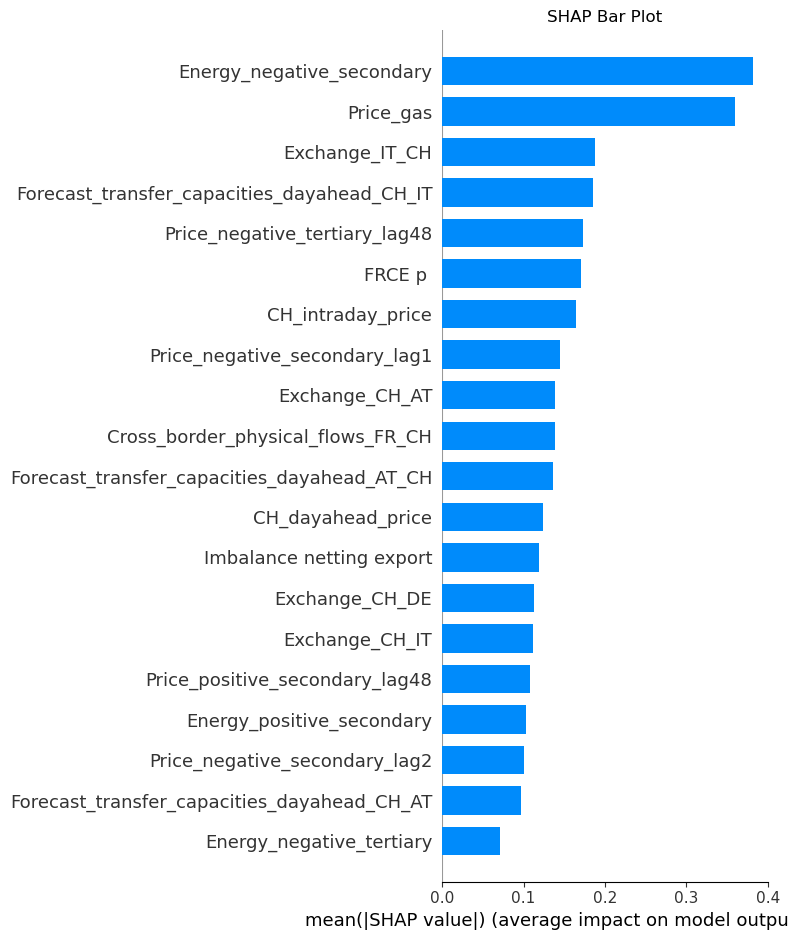

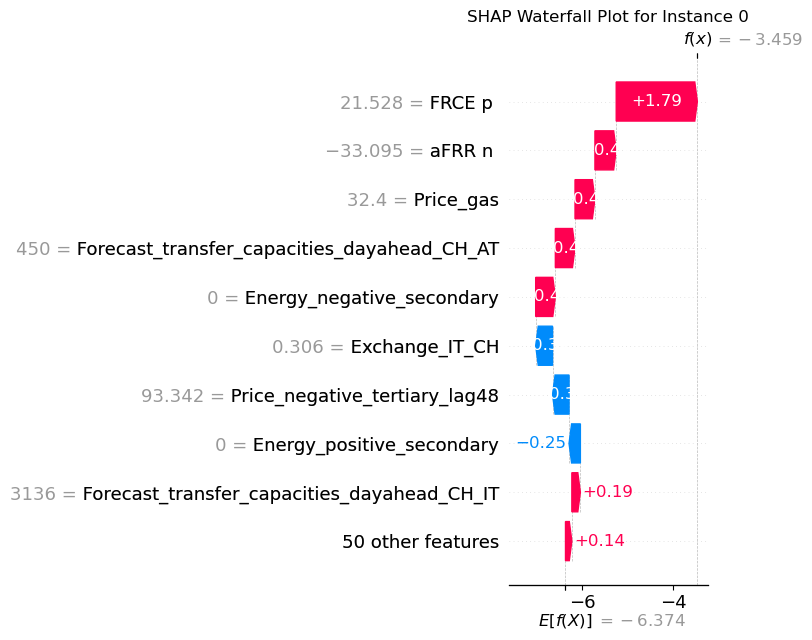

=== DynWeek_Price_positive_tertiary ===
Best params: {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 1.0, 'alpha': 0.01}
Recall: 0.206, Precision: 0.714, F1: 0.320
Confusion Matrix:
 [[2255   22]
 [ 212   55]]

Performing SHAP Value Analysis...


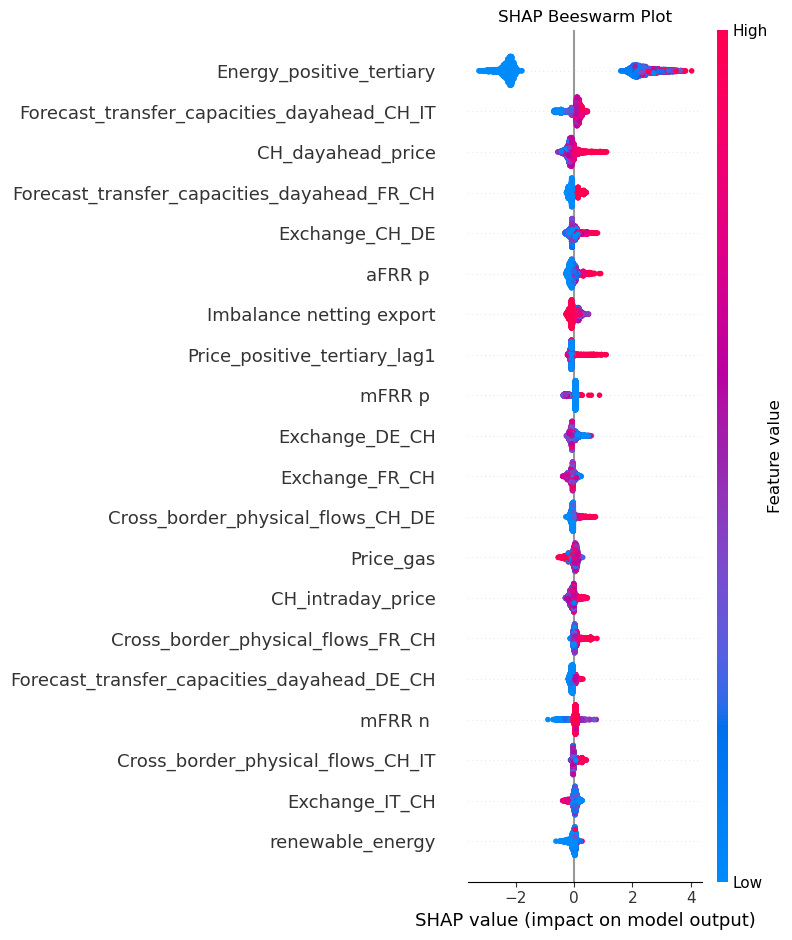

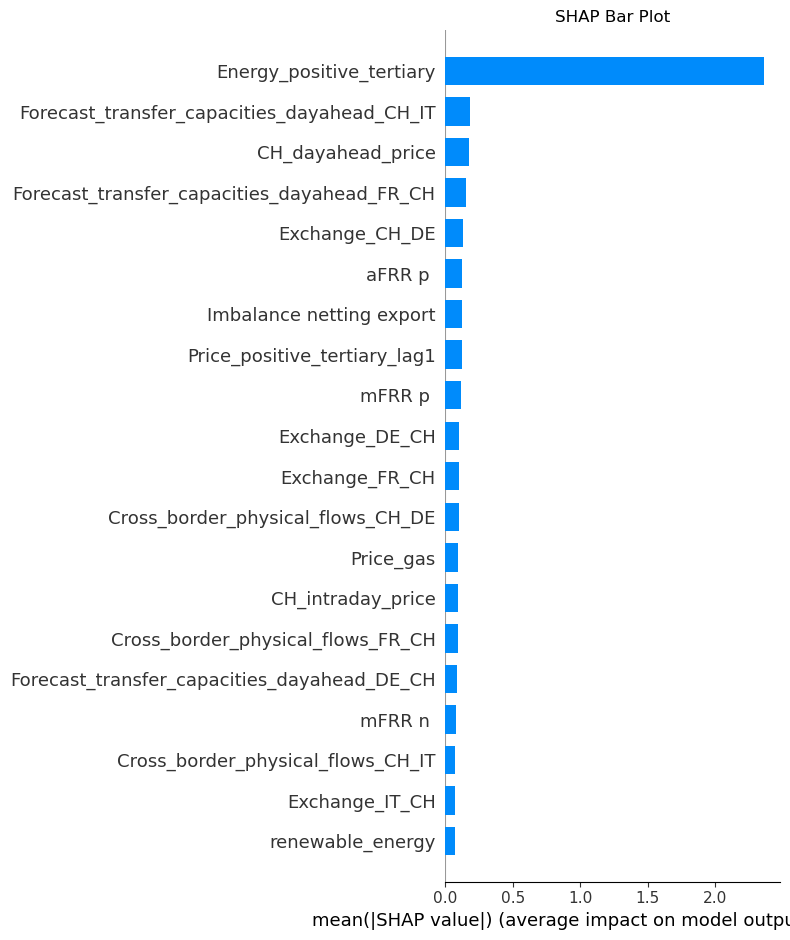

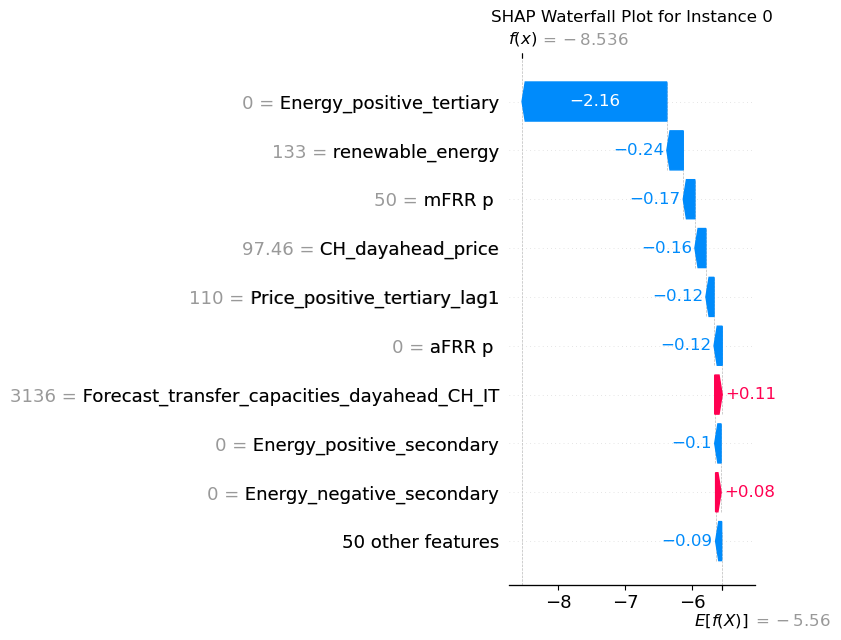

=== DynWeek_Price_negative_tertiary ===
Best params: {'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.01, 'colsample_bytree': 0.7, 'alpha': 0.3}
Recall: 0.199, Precision: 0.933, F1: 0.328
Confusion Matrix:
 [[2259    4]
 [ 225   56]]

Performing SHAP Value Analysis...


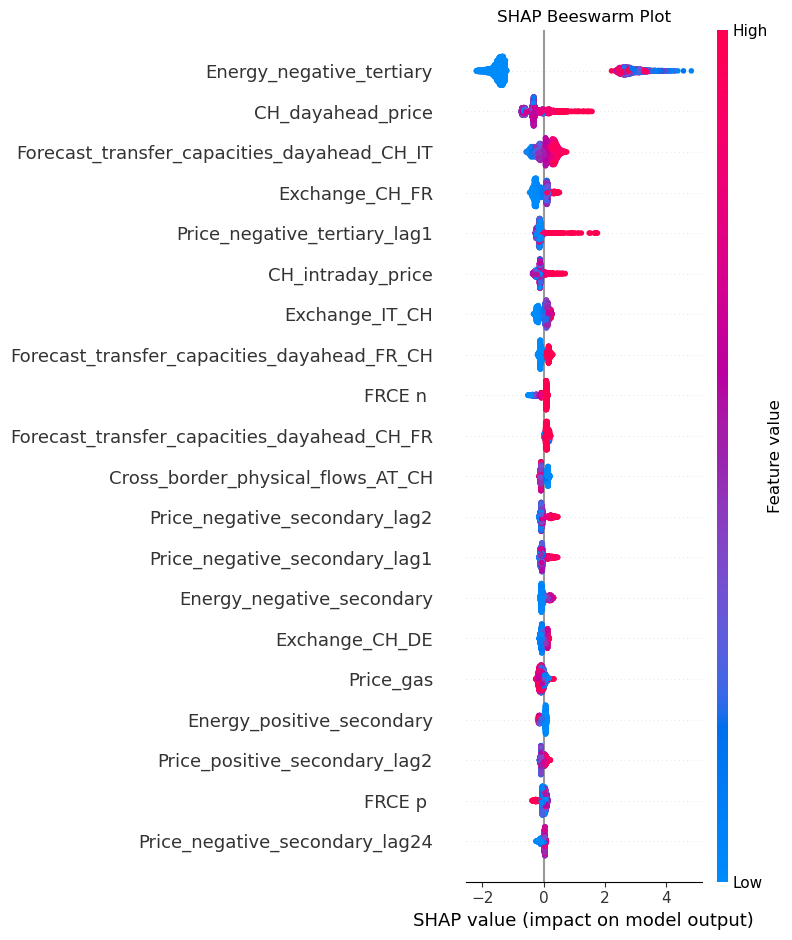

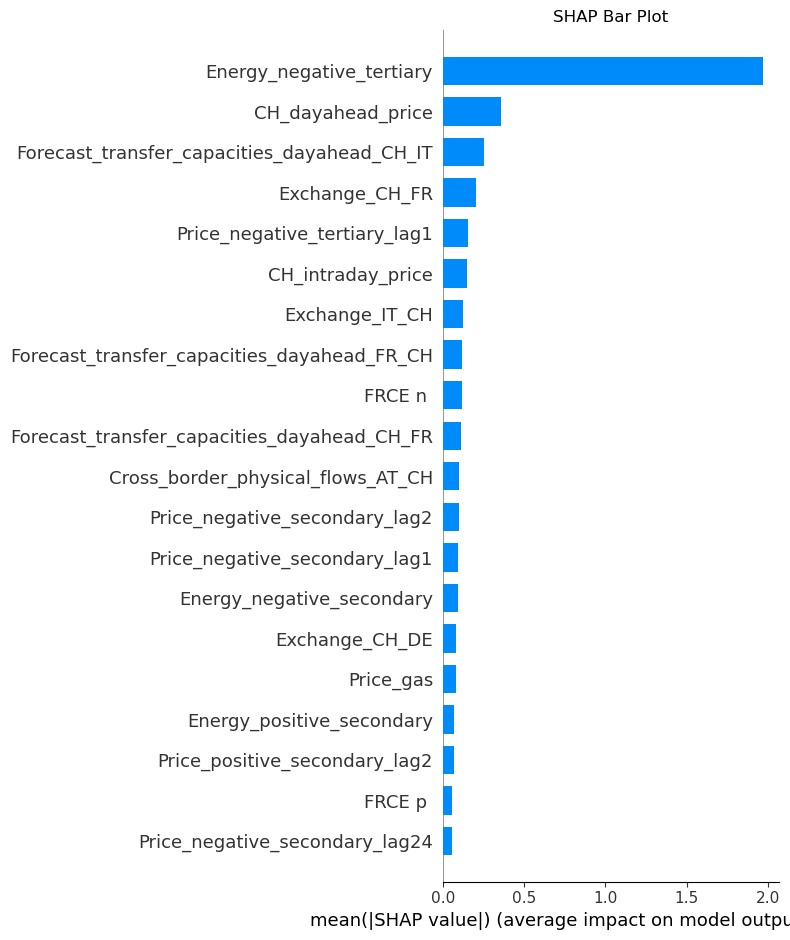

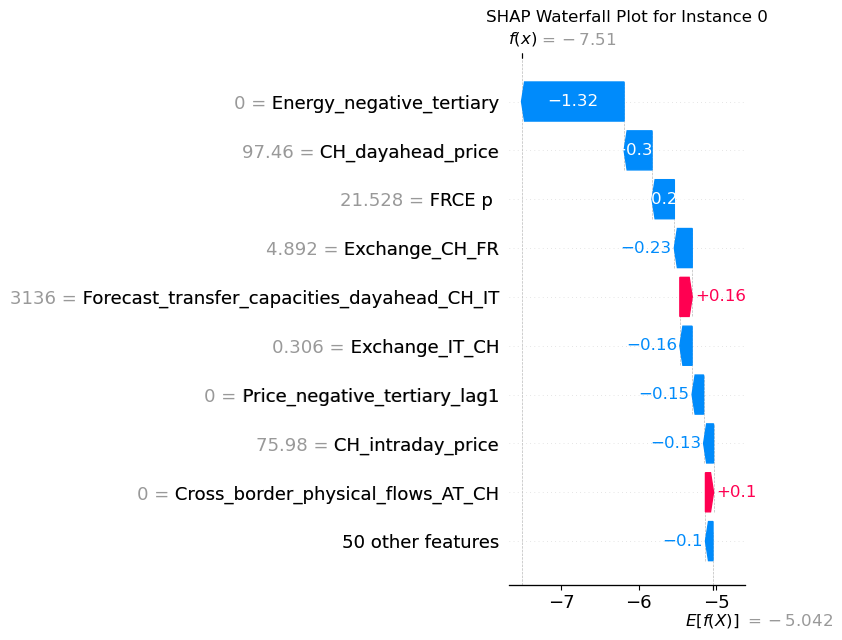

In [ ]:
df_dynweek_results = []
for t in targets:
    abs_series = df[t].abs()
    # Weekly rolling threshold
    roll_mean = abs_series.rolling(window=rolling_time, min_periods=1).mean()
    roll_std  = abs_series.rolling(window=rolling_time, min_periods=1).std()
    week_thr  = roll_mean + k_std * roll_std
    df[f'is_spike_{t}_dynweek'] = (abs_series >= week_thr).astype(int)

    # Train/test labels
    y_week = df[f'is_spike_{t}_dynweek']
    y_tr_week, y_te_week = y_week.loc[:split_date], y_week.loc[split_date:]

    # Evaluate
    _, rec_w, pre_w, f1_w, _ = analyze_xgb_model(
        X_train, y_tr_week, X_test, y_te_week,
        name=f"DynWeek_{t}"
    )
    df_dynweek_results.append({
        'target': t,
        'weekly_thr_last': week_thr.iloc[-1],
        'recall_week': rec_w,
        'precision_week': pre_w,
        'f1_week': f1_w
    })



## Summary

### Static

Static Threshold Summary:                      target  threshold  recall_full  precision_full   f1_full
0  Price_positive_secondary    194.750     0.875000        0.712575  0.785479
1  Price_negative_secondary     86.756     0.616848        0.681682  0.647646
2   Price_positive_tertiary    143.992     0.889785        0.730684  0.802424
3   Price_negative_tertiary     88.000     0.900000        0.808383  0.851735


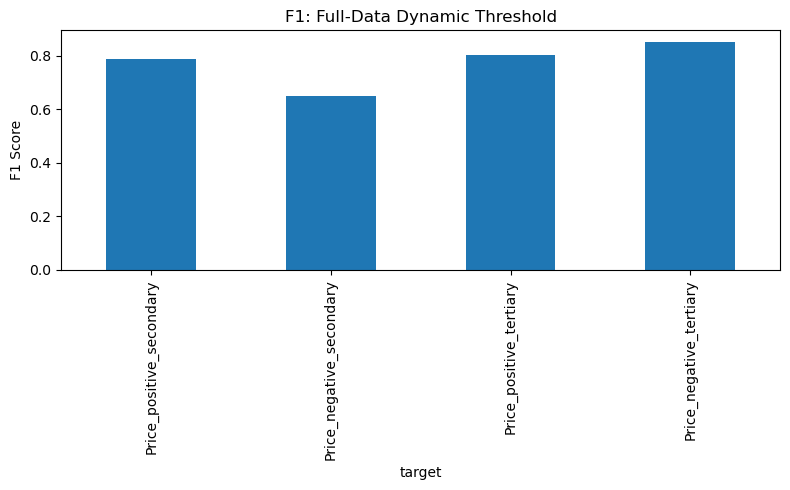

In [ ]:
df_stat = pd.DataFrame(static_results)
print("Static Threshold Summary:", df_stat)
plt.figure(figsize=(8,5))
df_stat.set_index('target')['f1_full'].plot(kind='bar')
plt.ylabel('F1 Score')
plt.title('F1: Full-Data Dynamic Threshold')
plt.tight_layout()
plt.show()


### Full dynamic

Full-Data Dynamic Threshold Results:                      target    full_thr  recall_full  precision_full   f1_full
0  Price_positive_secondary  229.031060     0.825000        0.682759  0.747170
1  Price_negative_secondary  175.605341     0.200000        0.600000  0.300000
2   Price_positive_tertiary  193.422418     0.500000        0.780000  0.609375
3   Price_negative_tertiary  124.681604     0.568182        0.568182  0.568182


<Figure size 800x500 with 0 Axes>

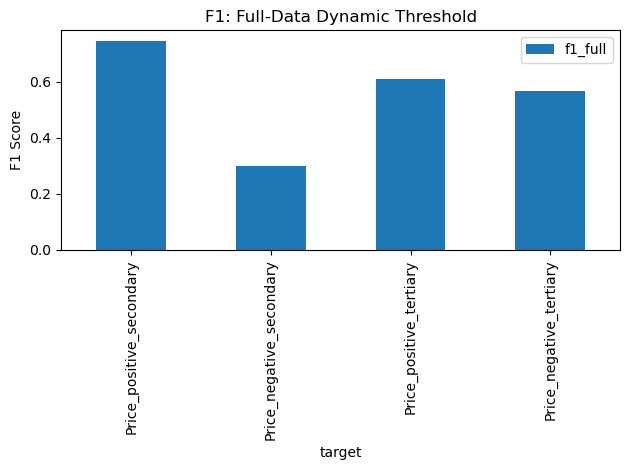

In [ ]:
# Summarize full-data dynamic
df_dynfull = pd.DataFrame(df_dynfull_results)
print("Full-Data Dynamic Threshold Results:", df_dynfull)
plt.figure(figsize=(8,5))
df_dynfull.set_index('target')[['f1_full']].plot(kind='bar')
plt.ylabel('F1 Score')
plt.title('F1: Full-Data Dynamic Threshold')
plt.tight_layout()
plt.show()

### Weekly dynamic

Weekly Rolling Dynamic Threshold Results:                      target  weekly_thr_last  recall_week  precision_week  \
0  Price_positive_secondary       176.999164     0.360577        0.882353   
1  Price_negative_secondary       114.491196     0.108434        0.692308   
2   Price_positive_tertiary       132.047437     0.205993        0.714286   
3   Price_negative_tertiary       146.205264     0.199288        0.933333   

    f1_week  
0  0.511945  
1  0.187500  
2  0.319767  
3  0.328446  


<Figure size 800x500 with 0 Axes>

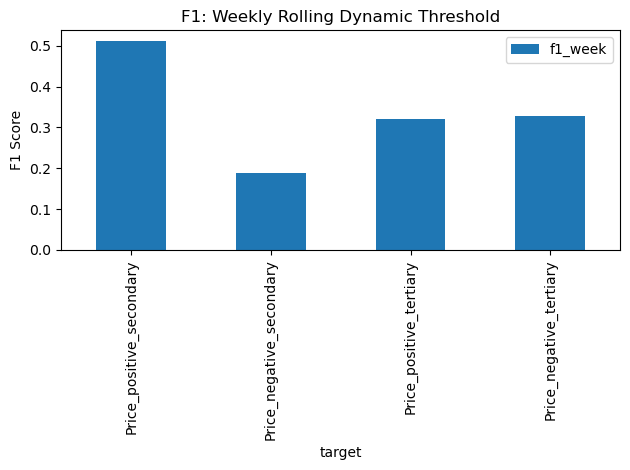

In [ ]:
# Summarize weekly rolling dynamic
df_dynweek = pd.DataFrame(df_dynweek_results)
print("Weekly Rolling Dynamic Threshold Results:", df_dynweek)
plt.figure(figsize=(8,5))
df_dynweek.set_index('target')[['f1_week']].plot(kind='bar')
plt.ylabel('F1 Score')
plt.title('F1: Weekly Rolling Dynamic Threshold')
plt.tight_layout()
plt.show()